# Understand your NLP models

This is a torturial on how to utilize Interpreter class to explain certain hidden layers in your NLP models. We provide the explanation by measuring the information of input words ${\bf x}_1,...,{\bf x}_n$ that is encoded in hidden state ${\bf s} = \Phi({\bf x})$. The method is from paper [*Towards a Deep and Unified Understanding of Deep Neural Models in NLP*](https://www.microsoft.com/en-us/research/publication/towards-a-deep-and-unified-understanding-of-deep-neural-models-in-nlp/) that is accepted by **ICML 2019**. In this torturial, we provide a simple example for you to start quickly.

In [1]:
import torch
from torch import nn
import sys

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

# Suppose your input is x, and the sentence is simply "1 2 3 4 5"
x = torch.randn(5, 256) / 100
x = x.to(device)
words = ["1", "2", "3", "4", "5"]

# Suppose your hidden state s = Phi(x), where
# Phi = 10 * word[0] + 20 * word[1] + 5 * word[2] - 20 * word[3] - 10 * word[4]
def Phi(x):
    W = torch.tensor([10.0, 20.0, 5.0, -20.0, -10.0]).to(device)
    return W @ x


# Suppose this is your dataset used for training your models
dataset = [torch.randn(5, 256) / 100 for _ in range(100)]

## Create an Interpreter instance

To explain a certain $\bf x$ and certain $\Phi$, you need to create an Interpreter instance, and pass your $\bf x$, $\Phi$ and regularization term (which is the standard variance of the hidden state r.v. $\bf S$) to it. We also provide a simple function to calculate the regularization term that is needed in this method.

In [2]:
from Interpreter import calculate_regularization, Interpreter

# calculate the regularization term.
regularization = calculate_regularization(dataset, Phi, device=device)

# create the interpreter instance
# we recommend you to set hyper-parameter *scale* to 10 * Std[word_embedding_weight], 10 * 0.1 in this example
interpreter = Interpreter(
    x=x, Phi=Phi, regularization=regularization, scale=10 * 0.1, words=words
)
interpreter.to(device)

Interpreter()

## Train the Interpreter

Then, we need to train our interpreter to let it find the information loss in each input word ${\bf x}_i$ when they reach hidden state $\bf s$. You can control the iteration and learning rate when training.

In [3]:
# Train the interpreter by optimizing the loss
interpreter.optimize(iteration=5000, lr=0.5, show_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 924.76it/s]


## Show and visualize results

After training, we can show the sigma (directly speaking, it is the range that every word can change without changing $\bf s$ too much) we have got. Sigma somewhat stands for the information loss of word ${\bf x}_i$ when it reaches $\bf s$.

In [4]:
# Show the sigma we get
interpreter.get_sigma()

array([0.00315634, 0.00181308, 0.00633237, 0.00174878, 0.0030807 ],
      dtype=float32)

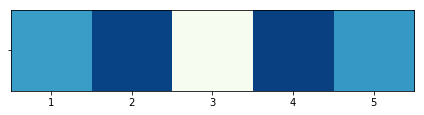

In [5]:
# Visualize the information loss of our sigma
interpreter.visualize()

We can see that the second and forth words are important to ${\bf s} = \Phi({\bf x})$, which is reasonable because the weights of them are larger.